In [104]:
#import
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from torch.utils.tensorboard import SummaryWriter
#from tensorflow.summary import FileWriter


In [ ]:
seed = 42
np.random.seed(seed)
random.seed(seed)
pca_t= True

In [105]:
df= pd.read_csv('ml-25m/dataset.csv')

### Data Preprocessing

In [106]:
#split data and labels 
X = df.drop(['rating'], axis=1)
y = df['rating']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

#count the numebr of x_train x_val and x_test
print("Number of train set: ", X_train.shape[0])
print("Number of validation set: ", X_val.shape[0])
print("Numebr of test set: ", X_test.shape[0])

Number of train set:  9946
Number of validation set:  1106
Numebr of test set:  2764


In [107]:
if pca_t == True:
    pca = PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    X_test = pca.transform(X_test)
    print ("PCA is applied")
else:
    print ("PCA is not applied")

PCA is applied


### Regressione Lineare:

**Senza PCA:**
- Mean Squared Error: 0.00544
- R2-Square: 0.97543

**Con PCA:**
- Mean Squared Error: 0.00643
- R2-Square:  0.97096


In [68]:
log_name = f"linear_regression"
if pca_t == True:
    writer = SummaryWriter(f"risultati/Machine_Learning_trad/pca/Linear_Regression/{log_name}")
    print("PCA")
else:
    writer = SummaryWriter(f"risultati/Machine_Learning_trad/no_pca/Linear_Regression/{log_name}")
    print("NO PCA")

lin_regr_model = linear_model.LinearRegression()
lin_regr_model.fit(X_train, y_train)
y_pred = lin_regr_model.predict(X_test)

# Compute the RSS
mse = mean_squared_error(y_test, y_pred) 

writer.add_scalar('Loss', mse)
writer.flush()

# Compute the R-square index
rsquare = r2_score(y_test, y_pred) 

print('Mean Square Error:', mse)
print('R2-square:', rsquare)

NO PCA


Mean Square Error: 0.00544540691904858
R2-square: 0.9754341910082425


### Ridge Regression

**no PCA**
- MSE: 0.00531
- R2-square: 0.97600

**PCA**
- Mean Squared Error: 0.00639
- R2- Squared: 0.97114

In [69]:
# Creazione del modello Ridge
ridge_model = Ridge()

# Definisci i parametri da cercare con la grid search
param_grid= {'alpha':[0.0001, 0.001, 0.1, 0.5, 1, 2, 3, 4, 5, 6, 10, 20]}

# Creazione dell'oggetto di Grid Search con cross-validation
grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

# Addestramento del modello sulla grid search
grid_search.fit(X_train, y_train)

# Estrai il miglior valore di alpha trovato
best_alpha = grid_search.best_params_['alpha']

print("Miglior alpha trovato:", best_alpha)

Miglior alpha trovato: 3


In [70]:
if pca_t == True:
    writer = SummaryWriter(f"tradML/risultati_cv/pca/Ridge_Regression/")
    print("PCA")
else:
    writer = SummaryWriter(f"tradML/risultati_cv/no_pca/Ridge_Regression/")
    print("NO PCA")

NO PCA


In [71]:
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_alpha', 'mean_test_score']]
results['mean_test_score'] = results['mean_test_score'] * -1  # Inverti il segno dell'errore quadratico medio

# Salva i risultati in TensorBoard
if pca_t:
    writer = SummaryWriter(f"risultati/Machine_Learning_trad/pca/Ridge_Regression")
else:
    writer = SummaryWriter(f"risultati/Machine_Learning_trad/no_pca/Ridge_Regression/")

for index, row in results.iterrows():
    mse = row['mean_test_score']
    alpha = row['param_alpha']
    writer.add_hparams({"alpha": alpha}, {"mse": mse})
    writer.flush()

writer.close()

In [72]:
ridge = pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
ridge = ridge.T
if pca_t == True:
    ridge.to_csv('tradML/b_params/pca/ridge.csv', index=False)
else:
    ridge.to_csv('tradML/b_params/no_pca/ridge.csv', index=False)

In [73]:
# Addestra il modello Ridge con il miglior alpha trovato sui dati di addestramento
best_ridge_model = Ridge(alpha=best_alpha)
best_ridge_model.fit(X_train, y_train)

# Calcolo delle predizioni sui dati di test
y_test_pred = best_ridge_model.predict(X_test)

# Calcolo delle metriche di valutazione
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Stampa il miglior valore di alpha e le metriche di valutazione
#print("Miglior alpha trovato:", best_alpha)
print("MSE su dati di test:", mse_test)
print("R2 su dati di test:", r2_test)


MSE su dati di test: 0.005319102663833808
R2 su dati di test: 0.9760039861134711


### Lasso Regression

**no PCA**
- Mean Squared Error: 0.00542
- R2- Squared: 0.97553

**PCA**
- Mean Squared Error:  0.00641
- R2- Squared: 0.97106

In [74]:
lasso_model= Lasso()

In [75]:
param_grid= {'alpha': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
grid_search= GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_param= grid_search.best_estimator_
print("Miglior hyperparametro", best_param)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.527e+00, tolerance: 1.880e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.996e+00, tolerance: 1.910e-01
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.742e+00, toleranc

Miglior hyperparametro Lasso(alpha=1e-05)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [76]:
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/pca/lasso.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/no_pca/lasso.csv")

In [77]:
#take only neg_mean_squared_error and convert to positive
results= pd.DataFrame(grid_search.cv_results_)
results = results[['mean_test_score', 'param_alpha']]
results['mean_test_score']= -1*results['mean_test_score']

#save mse to tensorboard
if pca_t == True:
    writer= SummaryWriter(f'risultati/Machine_Learning_trad/pca/Lasso/')
else:
    writer= SummaryWriter(f'risultati/Machine_Learning_trad/no_pca/Lasso/')
for i, rows in results.iterrows():
    mse= rows['mean_test_score']
    alpha= rows['param_alpha']
    writer.add_hparams({'alpha': alpha}, {'mse': mse})
    writer.flush()
writer.close()

In [78]:
lasso_model= pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
lasso_model= lasso_model.T

if pca_t == True:
    lasso_model.to_csv('tradML/b_params/pca/lasso.csv', index=False)
else:
    lasso_model.to_csv('tradML/b_params/no_pca/lasso.csv', index=False)

In [79]:
lasso_model = Lasso(alpha=best_param.alpha)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)   

print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print("R2 score: ", r2_score(y_test, y_pred))


Mean squared error:  0.005423553353396875
R2 score:  0.9755327787772686


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.046e+01, tolerance: 2.373e-01
  model = cd_fast.enet_coordinate_descent(


In [80]:
if pca_t == False:
    #print null coefficients and name of lasso without pca
    lasso_coeff= pd.DataFrame({'feature': X_train.columns, 'coefficient': lasso_model.coef_})
    lasso_coeff= lasso_coeff[lasso_coeff['coefficient']==0]
    print("Numero di featurs con coefficiente 0: ", lasso_coeff.shape[0])

    lasso_coeff= pd.DataFrame({'feature': X_train.columns, 'coefficient': lasso_model.coef_})
    lasso_coeff= lasso_coeff[lasso_coeff['coefficient']==0]
    X_zero= lasso_coeff['feature'].tolist()
    #correlarion between features set to 0 and y
    corr= df[X_zero].corrwith(y)
    display(corr.head(10))

Numero di featurs con coefficiente 0:  146


007           -0.097706
1920s          0.379278
3d            -0.153728
aardman        0.060788
afterlife     -0.079177
alcoholism     0.206545
almodovar      0.083976
amnesia        0.062696
animation      0.024383
arms dealer   -0.073337
dtype: float64

### Random Forest Regressor

**no PCA**
- Mean Squared Error: 0.01272
- R2-socore: 0.94260

**PCA**
- Mean Squared Error: 0.03801
- R2-socore: 0.82850

In [81]:
rf= RandomForestRegressor()

param_grid= {
    'n_estimators': [10, 15, 20, 25, 30],
    'criterion': ['squared_error', 'friedman_mse'],
}

grid_search= GridSearchCV(estimator= rf, param_grid= param_grid, cv=5, scoring='neg_mean_squared_error', verbose= 2)
grid_search.fit(X_train, y_train)
best_param= grid_search.best_estimator_



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...........criterion=squared_error, n_estimators=10; total time=  58.8s
[CV] END ...........criterion=squared_error, n_estimators=10; total time= 1.3min
[CV] END ...........criterion=squared_error, n_estimators=10; total time= 1.5min
[CV] END ...........criterion=squared_error, n_estimators=10; total time= 1.4min
[CV] END ...........criterion=squared_error, n_estimators=10; total time= 1.2min
[CV] END ...........criterion=squared_error, n_estimators=15; total time= 1.6min
[CV] END ...........criterion=squared_error, n_estimators=15; total time= 1.8min
[CV] END ...........criterion=squared_error, n_estimators=15; total time= 1.9min
[CV] END ...........criterion=squared_error, n_estimators=15; total time= 1.9min
[CV] END ...........criterion=squared_error, n_estimators=15; total time= 1.6min
[CV] END ...........criterion=squared_error, n_estimators=20; total time= 2.3min
[CV] END ...........criterion=squared_error, n_e

In [82]:
print("Miglior hyperparametro", best_param)


Miglior hyperparametro RandomForestRegressor(n_estimators=30)


In [83]:
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/pca/random_forest.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/no_pca/random_forest.csv")

In [84]:
results= pd.DataFrame(grid_search.cv_results_)
results= results[['mean_test_score', 'param_n_estimators', 'param_criterion']]
results['mean_test_score']= -1*results['mean_test_score']

if pca_t == True:
    writer= SummaryWriter(f'risultati//Machine_Learning_trad/pca/Random_Forest/')
else:
    writer= SummaryWriter(f'risultati//Machine_Learning_trad/no_pca/Random_Forest/')
for i, rows in results.iterrows():
    mse= rows['mean_test_score']
    n_estimators= rows['param_n_estimators']
    criterion= rows['param_criterion']
    writer.add_hparams({'n_estimators': n_estimators, 'criterion': criterion}, {'mse': mse})
    writer.flush()
writer.close()

In [85]:
rf= pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
rf= rf.T
if pca_t == True:
    rf.to_csv('tradML/b_params/pca/random_forest.csv', index=False)
else:
    rf.to_csv('tradML/b_params/no_pca/random_forest.csv', index=False)

In [86]:
rf= RandomForestRegressor(n_estimators= best_param.n_estimators, criterion= best_param.criterion)
rf.fit(X_train, y_train)
y_pred= rf.predict(X_test)

print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print("R2 score: ", r2_score(y_test, y_pred))

Mean squared error:  0.012343934174509526
R2 score:  0.9443129349843314


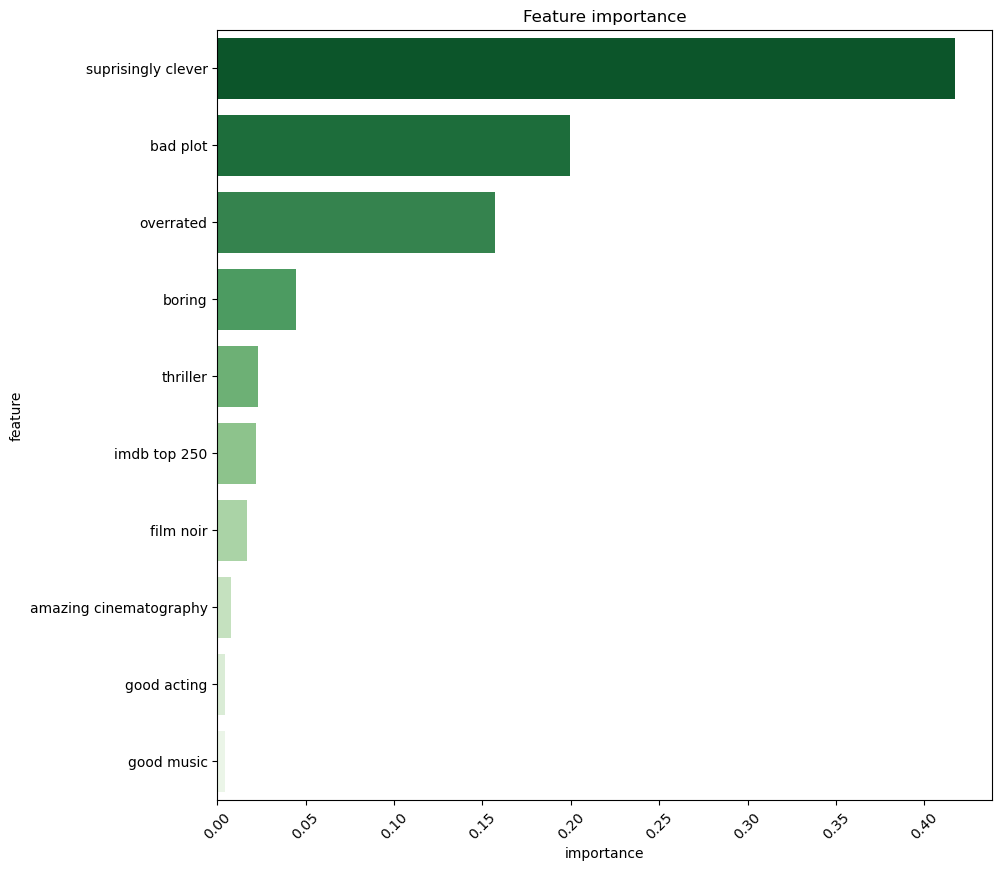

In [87]:
#stampare le 10 features più importanti con random forest
if pca_t == False:
    feature_importance = rf.feature_importances_
    importance_df= pd.DataFrame({'feature': X_train.columns, 'importance': feature_importance})
    importance_df= importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=importance_df.head(10), palette='Greens_r')
    plt.title('Feature importance')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("PCA is applied, no feature importance to show")

### KNN Regressor

**no PCA**
- Mean Squared Error: 0.04049
- R2-socore: 0.81729
  
**PCA**
- Mean Squared Error: 0.04015
- R2-socore: 0.81883

In [88]:
knn= KNeighborsRegressor()

param_grid= {
    'n_neighbors': [7, 9, 11, 13, 15, 17, 19, 20],
    'weights': ['uniform', 'distance'],
}

grid_search= GridSearchCV(estimator= knn, param_grid= param_grid, cv=5, scoring='neg_mean_squared_error', verbose= 2)
grid_search.fit(X_train, y_train)
best_param= grid_search.best_params_
print("Miglior hyperparametro", best_param)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................n_neighbors=7, weights=uniform; total time=   1.6s
[CV] END .....................n_neighbors=7, weights=uniform; total time=   1.8s
[CV] END .....................n_neighbors=7, weights=uniform; total time=   1.6s
[CV] END .....................n_neighbors=7, weights=uniform; total time=   1.3s
[CV] END .....................n_neighbors=7, weights=uniform; total time=   1.7s
[CV] END ....................n_neighbors=7, weights=distance; total time=   1.8s
[CV] END ....................n_neighbors=7, weights=distance; total time=   1.1s
[CV] END ....................n_neighbors=7, weights=distance; total time=   1.2s
[CV] END ....................n_neighbors=7, weights=distance; total time=   1.2s
[CV] END ....................n_neighbors=7, weights=distance; total time=   1.2s
[CV] END .....................n_neighbors=9, weights=uniform; total time=   1.2s
[CV] END .....................n_neighbors=9, wei

In [89]:
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/pca/knn.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/no_pca/knn.csv")

In [90]:
results= pd.DataFrame(grid_search.cv_results_)
results= results[['mean_test_score', 'param_n_neighbors', 'param_weights']]
results['mean_test_score']= -1*results['mean_test_score']

if pca_t == True:
    writer= SummaryWriter(f'risultati//Machine_Learning_trad/pca/KNN/')
else:
    writer= SummaryWriter(f'risultati//Machine_Learning_trad/no_pca/KNN/')

for i, rows in results.iterrows():
    mse= rows['mean_test_score']
    n_neighbors= rows['param_n_neighbors']
    weights= rows['param_weights']
    writer.add_hparams({'n_neighbors': n_neighbors, 'weights': weights}, {'mse': mse})
    writer.flush()

writer.close()  

In [91]:
knn= pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
knn= knn.T
if pca_t == True:
    knn.to_csv('tradML/b_params/pca/knn.csv', index=False)
else:
    knn.to_csv('tradML/b_params/no_pca/knn.csv', index=False)

In [92]:
knn= KNeighborsRegressor(n_neighbors= best_param['n_neighbors'], weights= best_param['weights'])
knn.fit(X_train, y_train)
y_pred= knn.predict(X_test)

print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print("R2 score: ", r2_score(y_test, y_pred))

Mean squared error:  0.04049981997445227
R2 score:  0.8172935730087196


### SVR

**no PCA:**
- MSE: 
- R2-Square: 

**PCA:**
- MSE: 0.00659
- R2-Square: 0.97022

In [108]:
svr= SVR()

param_grid= {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'C': [0.001, 0.01, 0.1, 1]
}

grid_search= GridSearchCV(estimator= svr, param_grid= param_grid, cv=5, scoring='neg_mean_squared_error', verbose= 2)
grid_search.fit(X_train, y_train)
best_param= grid_search.best_params_
print("Miglior hyperparametro", best_param)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[CV] END ................C=0.001, epsilon=0.001, kernel=poly; total time=  46.8s
[CV] END ................C=0.001, epsilon=0.001, kernel=poly; total time=  53.9s
[CV] END ................C=0.001, epsilon=0.001, kernel=poly; total time=  45.6s
[CV] END ................C=0.001, epsilon=0.001, kernel=poly; total time=  35.5s
[CV] END ................C=0.001, epsilon=0.001, kernel=poly; total time=  34.7s
[CV] END .................C=0.001, epsilon=0.001, kernel=rbf; total time=  36.5s
[CV] END .................C=0.001, epsilon=0.001, kernel=rbf; total time=  44.4s
[CV] END .................C=0.001, epsilon=0.001, kernel=rbf; total time=  36.5s
[CV] END .................C=0.001, epsilon=0.001, kernel=rbf; total time=  42.9s
[CV] END .................C=0.001, epsilon=0.001, kernel=rbf; total time=  43.9s
[CV] END .............C=0.001, epsilon=0.001, kernel=sigmoid; total time=  39.8s
[CV] END .............C=0.001, epsilon=0.001, kernel=sigmoid; total time=  44.8s
[CV] END .............C=0.00

In [109]:
if pca_t == True:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/pca/svr.csv")
else:
    pd.DataFrame(grid_search.cv_results_).to_csv(f"tradML/risultati_cv/no_pca/svr.csv")

In [110]:
results= pd.DataFrame(grid_search.cv_results_)
results= results[['mean_test_score', 'param_kernel', 'param_epsilon', 'param_C']]
results['mean_test_score']= -1*results['mean_test_score']

if pca_t == True:
    writer= SummaryWriter(f'risultati/Machine_Learning_trad/pca/SVR/')
else:
    writer= SummaryWriter(f'risultati/Machine_Learning_trad/no_pca/SVR/')
for i, rows in results.iterrows():
    mse= rows['mean_test_score']
    kernel= rows['param_kernel']
    epsilon= rows['param_epsilon']
    c= rows['param_C']
    writer.add_hparams({'C': c, 'epsilon': epsilon, 'kernel': kernel}, {'mse': mse})
    writer.flush()
writer.close()

In [111]:
svr= pd.DataFrame.from_dict(grid_search.best_params_, orient='index', columns=['value'])
svr= svr.T
if pca_t == True:
    svr.to_csv('tradML/b_params/pca/svr.csv', index=False)
else:
    svr.to_csv('tradML/b_params/no_pca/svr.csv', index=False)

In [112]:
svr= SVR(kernel= best_param['kernel'], epsilon= best_param['epsilon'], C= best_param['C'])
svr.fit(X_train, y_train)
y_pred= svr.predict(X_test)

print("Mean squared error: ", mean_squared_error(y_test, y_pred))
print("R2 score: ", r2_score(y_test, y_pred))

Mean squared error:  0.00659967092004883
R2 score:  0.9702269715302189
